## Advanced Demo for processing and displaying data ##

This notebook displays known objects around earth based on the official publicly available data from [space-track.org](https://space-track.org).

For calculation purposes [Orekit](https://orekit.org) an "An accurate and efficient core layer for space flight dynamics applications" is used.

First load the 3 line elements based file from disk

In [0]:
import java.nio.file.Files;
import java.nio.file.Paths;
var lines = Files.readAllLines(cwd.resolve("space-track-data/full-three-line.txt"));

Create a record to hold the data.

In [0]:
record Satellite(String name, String tle1, String tle2){};

Build a list of record objects representing the 3 line elements.

This implementation uses a Java preview feature called _Gatherers_ (see [JEP 473](https://openjdk.org/jeps/473))

In [0]:
import java.util.stream.Gatherers;
var satellites = lines.stream().gather(Gatherers.windowFixed(3))
     .map(l -> new Satellite(l.get(0).trim(), l.get(1), l.get(2)))
//     .filter(s -> s.name().contains("STARLINK"))
//     .filter(s -> s.name().contains(" DEB"))
     .toList();
satellites.size()

int: 27030

Show the list of satellites as a table

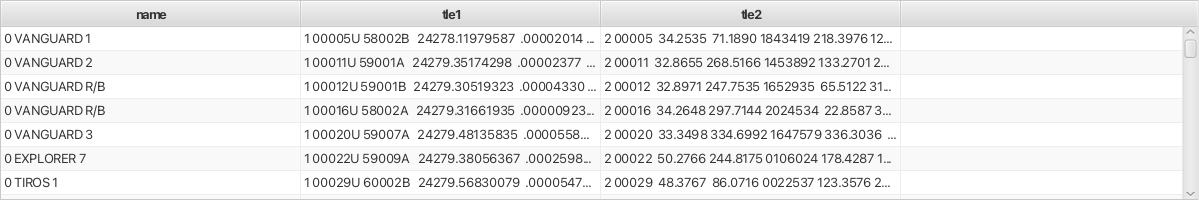

In [0]:
display(satellites)

In [0]:
addDependency("org.orekit:orekit:12.1.3");

In [0]:
import org.orekit.data.DataContext;
import org.orekit.data.DirectoryCrawler;
import org.orekit.data.NetworkCrawler;
import java.io.File;
import java.net.URL;

In [0]:
// This initializes orekit with latest data provided from orkeit gitlab. Due to file size this may take a while to download
var dp = new NetworkCrawler(new URL("https://gitlab.orekit.org/orekit/orekit-data/-/archive/master/orekit-data-master.zip"));
// If you want to this faster download the file from the beforehand URL and store it locally. 
// Comment the before line, uncomment the line below and make sure that the directory points to the place of the local copy
// Remember you can use cwd to get the current working directory of the notebook for relative data location
// var dp = new DirectoryCrawler(cwd.resolve("orekit-data").toFile());

DataContext.getDefault().getDataProvidersManager().addProvider(dp);

In [0]:
import java.time.LocalDateTime;
import org.orekit.time.AbsoluteDate;
import org.orekit.time.TimeScalesFactory;
var localDateTime = LocalDateTime.now();
var absoluteDate =new AbsoluteDate(localDateTime.getYear(), 
                localDateTime.getMonthValue(), localDateTime.getDayOfMonth(), 
                localDateTime.getHour(), localDateTime.getMinute(), localDateTime.getSecond(), 
                TimeScalesFactory.getUTC());
absoluteDate

AbsoluteDate: 2024-12-29T16:11:31.000Z

In [0]:
import javafx.geometry.Point3D;

In [0]:
import org.orekit.propagation.analytical.tle.TLE;
import org.orekit.propagation.analytical.tle.TLEPropagator;
var points = satellites.stream().parallel()
  .map(s -> new TLE(s.tle1(), s.tle2()))
  .map(tle -> TLEPropagator.selectExtrapolator(tle))
  .map(propagator -> propagator.getPVCoordinates(absoluteDate))
  .map(pv -> new Point3D((float) pv.getPosition().getY(), 
                         -(float) pv.getPosition().getZ(),
                         -(float) pv.getPosition().getX())).toList();

In [0]:
import javafx.scene.image.Image;
import javafx.scene.image.ImageView;
import javafx.scene.shape.Sphere;
import javafx.scene.paint.Color;
import javafx.scene.paint.PhongMaterial;
var world = new Image("https://eoimages.gsfc.nasa.gov/images/imagerecords/147000/147190/eo_base_2020_clean_720x360.jpg");
var worldView = new ImageView(world);
var semiMajorAxis = 63.781370*5;
var sphere = new Sphere(semiMajorAxis, 512);

var worldMaterial = new PhongMaterial();
worldMaterial.setSpecularMap(world);
worldMaterial.setDiffuseMap(world);
sphere.setMaterial(worldMaterial);

In [0]:
addDependency("org.fxyz3d:fxyz3d:0.6.0");

In [0]:
import javafx.scene.Group;
import javafx.scene.DepthTest;
import javafx.scene.SubScene;
import javafx.scene.SceneAntialiasing;
import javafx.scene.PerspectiveCamera;
import org.fxyz3d.utils.CameraTransformer;
import org.fxyz3d.shapes.primitives.ScatterMesh;
import org.fxyz3d.geometry.Point3D;

var fxyzPoints = points.stream().map(p -> new org.fxyz3d.geometry.Point3D(p.getX()/10000, p.getY()/10000, p.getZ()/10000)).toList();

var mesh = new ScatterMesh(fxyzPoints, true, 20, 0);

var camera = new PerspectiveCamera(true);
camera.setVerticalFieldOfView(false);
camera.setDepthTest(DepthTest.ENABLE);
camera.setNearClip(0.001);
camera.setFarClip(100000);
camera.setTranslateZ(-17500);

var cameraTransform = new CameraTransformer();
cameraTransform.getChildren().add(camera);

mesh.setTextureModeVertices3D(1530, p -> p.f);
var root3d = new Group(sphere, cameraTransform, mesh);
var subScene = new SubScene(root3d, 800, 800, true, SceneAntialiasing.DISABLED);

subScene.setCamera(camera);


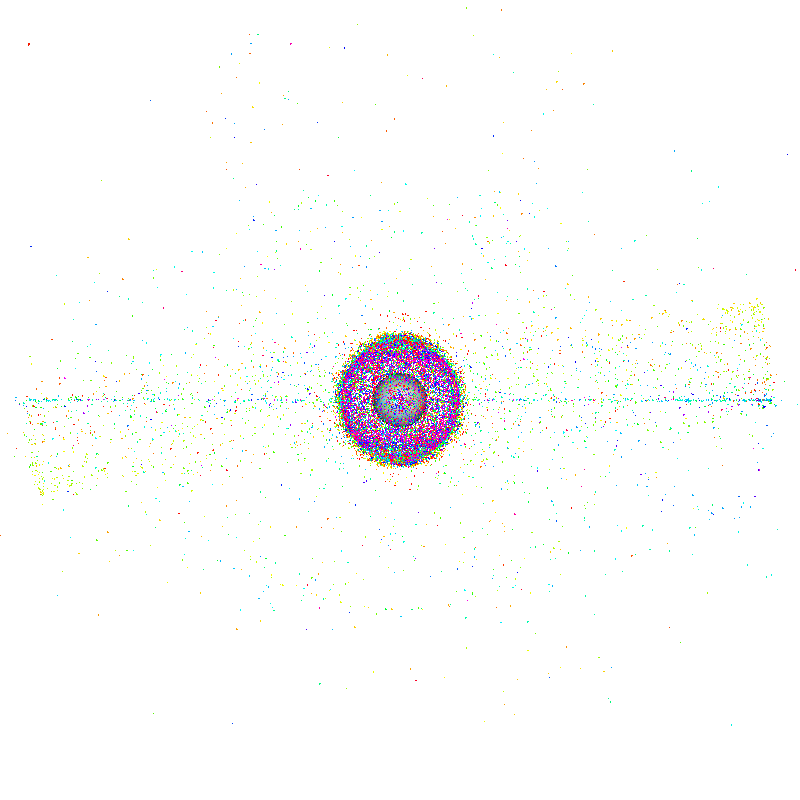

In [0]:
display(subScene)